# Creating a custom node

Welcome to the `RxInfer` documentation on creating custom factor graph nodes. In `RxInfer`, nodes represent distributions, and a variety of distributions are supported natively. However, in some cases, you may need to create a custom node that better fits the specific requirements of your model. This tutorial will guide you through the process of defining a custom node in RxInfer, step by step. By the end of this tutorial, you'll be able to create your own custom node and integrate it into your model.

To create a custom node in `RxInfer`, 4 steps are required:

- Notify `RxInfer` of the nodes existence with the `@node` macro.
- Define update rules for sum-product message passing with the `@rule` macro. If needed, messages requiring the approximate marginal distribution over variables (for example, structured approximation updates) can also be created with the `@rule` macro.
- Specify computations for marginal distributions of the relevant variables with the `@marginalrule` macro.
- Implement the computation of the Free Energy in a node with the `@average_energy` macro.

As an example, we will be recreating the node for the `Bernoulli` distribution. The `Bernoulli` distribution is a commonly used distribution in statistical modeling that represents a binary outcome, such as a coin flip. By recreating this node, we will be able to demonstrate the process of creating a custom node, from notifying `RxInfer` of the nodes existence to implementing the required methods. While this tutorial focuses on the `Bernoulli` distribution, the principles can be applied to creating custom nodes for other distributions as well. So let's get started!

## Defining the custom node

To begin creating a custom node, we first need to inform `RxInfer` that the new node exists. This is accomplished with the `@node` macro, which is exported by `RxInfer` and requires three arguments:

- The name of the node, which should be a `Type`. In this tutorial, we'll define a placeholder struct called `MyBernoulli` to serve as the name of our node.
- Whether the node is deterministic or stochastic. While most nodes in `RxInfer` are stochastic since they represent a distribution, it's also possible to define nodes for deterministic operations. Examples of deterministic nodes in `RxInfer` include the sum operation node and the product operation node.
- The interfaces of the node and any potential aliases. The interfaces are defined as the set of variables that a node operates on. For example, for the `Normal` distribution, this would be `[out, μ, σ]`. For our `MyBernoulli` distribution, we have the `out` and `p` interfaces. Since the `p` parameter is sometimes denoted as `θ`, we can add `θ` as an alias to the `p` parameter.

To get started, we'll import `RxInfer`, create the `MyBernoulli` `struct`, and call `@node` with the required parameters. We also implement the `mean` function for the `MyBernoulli` struct, as it is required in the update rule computations.

In [1]:
using RxInfer

struct MyBernoulli 
    p :: Real
end

Distributions.mean(d::MyBernoulli) = d.p

@node MyBernoulli Stochastic [out, (p, aliases = [θ])] 

## Defining rules for our node

In order to use our custom node, we should tell `RxInfer` how to send messages. The operation that transforms incoming messages into outgoing messages is called an update rule, and can be specified with the `@rule` macro. Here, we rely on conjugate computations. This is how `RxInfer` achieves high performance; by applying conjugate update rules where possible we are able to significantly speed up inference. We should define, for all interfaces, the conjugate computations that update the interface. We will start with the `out` interface. We know that the `out` interface should be `MyBernoulli` distributed. There are two possibilities of the distribution of the `p` parameter: A `Beta` distribution (the conjugate prior to the `Bernoulli` distribution) or a `PointMass` distribution (if the parameter `p`) is known. 

For the case of a `Beta` message coming into our node, the outgoing message will be the predictive posterior of the `Bernoulli` distribution with a `Beta` prior. Here we obtain $ p = \frac{\alpha}{\alpha + \beta}$, which coincides with the mean of the `Beta` distribution. Hence, we have our first update rule:

In [2]:
@rule MyBernoulli(:out, Marginalisation) (m_p :: Beta,) = MyBernoulli(mean(m_p))

Here, `m_p` is shorthand for "the sum-product message with input message for interface `p`". As we will see later, the structured approximation update rule for incoming message from `p` will have `q_p` as parameter.

The second rule is also straightforward; if `p` is known the outgoing message will be `MyBernoulli(p)`:

In [3]:
@rule MyBernoulli(:out, Marginalisation) (m_p :: PointMass,) = MyBernoulli(mean(m_p))

Continuing with the sum-product update rules, we now have to define the update rules towards the `p` interface. We can only do exact inference if the incoming message is known, which in the case of the `Bernoulli` distribution, means that the `out` message is a `PointMass` distribution that is either `0` or `1`. The updated Beta distribution for `p` will be:
$$ p \sim Beta(1 + out, 2 - out)$$
Which gives us the following update rule:

In [4]:
@rule MyBernoulli(:p, Marginalisation) (m_out :: PointMass,) = begin
    p = mean(m_out)
    Beta(one(p) + p, 2one(p) - p)
end

We will now cover our second set of update rules. The previously defined rules only work if computations related to our custom node are conjugate. However, if computations are not conjugate, we need to use a different learning strategy. In this case, we rely on updating based on the marginal distributions of incoming variables. There is a subtle difference between the incoming message from a node and the marginal distribution of that variable. The marginal distribution is the product of the incoming and outgoing message of that variable. However, since we are updating the outgoing messages, the outgoing messages we use in the computation of the marginal distribution are an approximation, and hence we obtain an approximate marginal. By iteratively updating our estimates of the outgoing messages and marginals, we get increasingly better approximations to the true posterior marginals. Update rules that operate on the marginals instead of the incoming messages are specified with the `q_{interface}` parameter name. With these update rules, we can support a slightly wider family of distributions. In this tutorial, we will only cover how to define these rules and not delve into the computations of these messages.

In [5]:
#rules towards out

@rule MyBernoulli(:out, Marginalisation) (q_p::PointMass,) = Bernoulli(mean(q_p))

@rule MyBernoulli(:out, Marginalisation) (q_p::Beta,) = Bernoulli(mean(q_p))

#rules towards p
@rule MyBernoulli(:p, Marginalisation) (q_out :: PointMass,) = begin
    p = mean(q_out)
    Beta(one(p) + p, 2one(p) - p)
end


@rule MyBernoulli(:p, Marginalisation) (q_out::MyBernoulli,) = begin
    p = mean(q_out)
    return Beta(one(p) + p, 2one(p) - p)
end

@rule MyBernoulli(:p, Marginalisation) (q_out::Categorical,) = begin
    p = probvec(q_out)
    @assert length(p) == 2 "MyBernoulli is only defined over its support {0,1}. It has received a Categorical message that does not have 2 categories."
    r = p[2]
    return Beta(one(r) + r, 2one(r) - r)
end

## Defining marginals for our node

To calculate the updated posterior marginal for our custom distribution, we need to provide the posterior marginals for the interfaces of our node in a `NamedTuple`. In our case, the posterior marginal for the observation is still the same `PointMass` distribution. However, to calculate the posterior marginal over `p`, we use `RxInfer`'s built-in `prod` functionality to multiply the `Beta` prior with the `Beta` likelihood. This gives us the updated posterior distribution, which is also a `Beta` distribution. We use `ProdAnalytical()` parameter to ensure that we multiply the two distributions analytically. This is done as follows:

In [6]:
@marginalrule Bernoulli(:out_p) (m_out::PointMass, m_p::Beta) = begin
    r = mean(m_out)
    p = prod(ProdAnalytical(), Beta(one(r) + r, 2one(r) - r), m_p)
    return (out = m_out, p = p)
end

## Defining the average energy for our node

Free Energy Minimization is performed by `RxInfer` when exact posterior distributions cannot be derived, which is almost always the case except for full conjugacy. In order to compute the Free Energy, `RxInfer` has to know how to compute a quantity known as the Average Energy, which is a component of the Free Energy in a node. The calculation of the Free Energy in nodes is critical in approximating the Free Energy in a model, which is the quantity we aim to minimize. The Average Energy of a distribution $f(\bar{x})$ is defined as:
$$ \mathbb{E}_{q(\bar{x})}\left[ \log f(\bar{x}\right]$$
In our `Bernoulli` example, $f(p, x) = p^{x} * (1-p)^{1-x}$, so we have that $\log f(p, x) = x \cdot \log p + (1-x) \log [1-p]$. The expectation under $q(p, x) = q(p)q(x)$ is then equal to:
$$ \mathbb{E}_{q(p, x)}\left[ \mathbb{E}_{q(x)}[x] * \mathbb{E}_{q(p)}[\log{p}] + (1 - \mathbb{E}_{q(x)}[x]) *\mathbb{E}_{q(p)}[1-\log{p}]\right]$$
Which is what we implemented below. Note that `mean(mirrorlog, q(x))` is equal to $\mathbb{E}_{q(x)}[1-\log{x}]$.

In [7]:
@average_energy Bernoulli (q_out::Any, q_p::Any) = -mean(q_out) * mean(log, q_p) - (1.0 - mean(q_out)) * mean(mirrorlog, q_p)

## Using our node in a model

With all the necessary functions defined, we can proceed to test our custom node in an experiment. For this experiment, we will generate a dataset from a Bernoulli distribution with a fixed success probability of 0.75. Next, we will define a probabilistic model that has a `Beta` prior and a `MyBernoulli` likelihood. The `Beta` prior will be used to model our prior belief about the probability of success. The MyBernoulli likelihood will be used to model the generative process of the observed data. We start by generating the dataset:

In [8]:
using Random

rng = MersenneTwister(42)
n = 500
p_real = 0.75
distribution = Bernoulli(p_real)

dataset = float.(rand(rng, distribution, n));

Next, we define our model. Note that we use the `MyBernoulli` node in the model. The model consists of a single latent variable `p`, which has a `Beta` prior and is the parameter of the `MyBernoulli` likelihood. The `MyBernoulli` node takes the value of `p` as its parameter and returns a binary observation. We set the hyperparameters of the `Beta` prior to be 4 and 8, respectively, which correspond to a distribution slightly biased towards higher values of `p`. The model is defined as follows:

In [9]:
@model function coin_model_mybernoulli(n)

    # `datavar` creates data 'inputs' in our model
    y = datavar(Float64, n)

    # We endow θ parameter of our model with some prior
    p ~ Beta(4.0, 8.0)

    # We assume that outcome of each coin flip is governed by the MyBernoulli distribution
    for i in 1:n
        y[i] ~ MyBernoulli(p)
    end

end

Finally, we can run inference with this model and the generated dataset:

In [10]:
result_mybernoulli = inference(
    model = coin_model_mybernoulli(length(dataset)), 
    data  = (y = dataset, ),
)

Inference results:
  Posteriors       | available for (p)


We have now completed our experiment and obtained the posterior marginal distribution for p through inference. To evaluate the performance of our inference, we can compare the estimated posterior to the true value. In our experiment, the true value for p is 0.75, and we can see that the estimated posterior has a mean of approximately 0.713, which shows that our custom node was able to succesfully pass messages towards the `p` variable in order to learn the true value of the parameter.

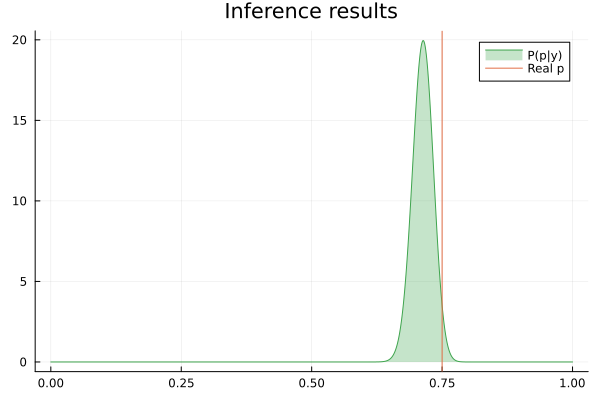

In [11]:
using Plots

rθ = range(0, 1, length = 1000)

p = plot(title = "Inference results")

plot!(rθ, (x) -> pdf(result_mybernoulli.posteriors[:p], x), fillalpha=0.3, fillrange = 0, label="P(p|y)", c=3)
vline!([p_real], label="Real p")

As a sanity check, we can create the same model with the `RxInfer` built-in node `Bernoulli` and compare the resulting posterior distribution with the one obtained using our custom `MyBernoulli` node. This will give us confidence that our custom node is working correctly. We use the `Bernoulli` node with the same `Beta` prior and the observed data, and then run inference. We can compare the two posterior distributions and observe that they are exactly the same, which indicates that our custom node is performing as expected.

In [12]:
@model function coin_model(n)
    
    y = datavar(Float64, n)
    p ~ Beta(4.0, 8.0)

    for i in 1:n
        y[i] ~ Bernoulli(p)
    end

end
result_bernoulli = inference(
    model = coin_model(length(dataset)), 
    data  = (y = dataset, ),
)
println(result_bernoulli.posteriors[:p] == result_mybernoulli.posteriors[:p])

true


Congratulations! You have succesfully implemented your own custom node in `RxInfer`. We went through the definition of a node to the implementation of the update rules and marginal posterior calculations. Finally we tested our custom node in a model and checked if we implemented everything correctly.